In [1]:
import h5py
import ast
from astropy.table import QTable, Table, Column, vstack
import astropy.units as u
import astropy
%matplotlib inline
%matplotlib notebook
import pandas as pd
import numpy as np
import simsurvey
import simsurvey_tools as sst
import matplotlib.pylab as plt
import pandas as pd
import os
from ZTF_hdf5 import Write_LightCurve, Read_LightCurve, Plot_LightCurve
from ztf_simu import Simul_lc

In [2]:
home_dir = os.environ.get('HOME')
folder_dir = os.path.join(home_dir, 'ZTF/data/')
print(folder_dir)

/Users/manon/ZTF/data/


# Generate light curves

In [3]:
lc = Simul_lc(folder_dir=folder_dir, sfd98File='sfd98', rcidFile='ZTF_corners_rcid.txt', 
                csvFile ='2018_all_logs_from_dr1_rcid_zp_from_masci.csv', 
                z_range=(0.01, 0.1), dec_range=(-30, 90), n_det=1, ntransient=1000, seed=70, threshold=1)()

/Users/manon/ZTF/simsurvey/simsurvey/simulsurvey.py:1577: RuntimeWarning: invalid value encountered in true_divide
  mask_det = lc['flux']/lc['fluxerr'] > thr
/Users/manon/ZTF/simsurvey/simsurvey/simulsurvey.py:1577: RuntimeWarning: invalid value encountered in true_divide
  mask_det = lc['flux']/lc['fluxerr'] > thr
/Users/manon/ZTF/simsurvey/simsurvey/simulsurvey.py:1577: RuntimeWarning: invalid value encountered in true_divide
  mask_det = lc['flux']/lc['fluxerr'] > thr
/Users/manon/ZTF/simsurvey/simsurvey/simulsurvey.py:1577: RuntimeWarning: invalid value encountered in true_divide
  mask_det = lc['flux']/lc['fluxerr'] > thr
/Users/manon/ZTF/simsurvey/simsurvey/simulsurvey.py:1577: RuntimeWarning: invalid value encountered in true_divide
  mask_det = lc['flux']/lc['fluxerr'] > thr
/Users/manon/ZTF/simsurvey/simsurvey/simulsurvey.py:1577: RuntimeWarning: invalid value encountered in true_divide
  mask_det = lc['flux']/lc['fluxerr'] > thr
/Users/manon/ZTF/simsurvey/simsurvey/simulsurv

/Users/manon/ZTF/simsurvey/simsurvey/simulsurvey.py:1577: RuntimeWarning: invalid value encountered in true_divide
  mask_det = lc['flux']/lc['fluxerr'] > thr
/Users/manon/ZTF/simsurvey/simsurvey/simulsurvey.py:1577: RuntimeWarning: invalid value encountered in true_divide
  mask_det = lc['flux']/lc['fluxerr'] > thr
/Users/manon/ZTF/simsurvey/simsurvey/simulsurvey.py:1577: RuntimeWarning: invalid value encountered in true_divide
  mask_det = lc['flux']/lc['fluxerr'] > thr
/Users/manon/ZTF/simsurvey/simsurvey/simulsurvey.py:1577: RuntimeWarning: invalid value encountered in true_divide
  mask_det = lc['flux']/lc['fluxerr'] > thr
/Users/manon/ZTF/simsurvey/simsurvey/simulsurvey.py:1577: RuntimeWarning: invalid value encountered in true_divide
  mask_det = lc['flux']/lc['fluxerr'] > thr
/Users/manon/ZTF/simsurvey/simsurvey/simulsurvey.py:1577: RuntimeWarning: invalid value encountered in true_divide
  mask_det = lc['flux']/lc['fluxerr'] > thr


progress_bar_succes


In [4]:
## First light curve
lc[0]

time,band,flux,fluxerr,zp,zpsys,field,ccd,comment
float64,str4,float64,float64,float64,str2,int64,int64,str1
58373.404722199775,ztfg,15.623218511732416,12.79469670965293,26.275,ab,653,27,
58373.40564810019,ztfg,-11.055012944967462,13.52165950783963,26.275,ab,653,27,
58373.458449100144,ztfr,13.647691364887748,16.107568823981346,26.325,ab,653,27,
58374.38437499991,ztfr,-12.84230834958291,16.107568823981346,26.325,ab,653,27,
58374.426562500186,ztfg,2.858760636870903,11.246826503806982,26.275,ab,653,27,
58375.40913189994,ztfr,7.132087066633745,14.422149583657989,26.325,ab,653,27,
58375.44765050011,ztfg,10.507581124937465,11.885843172311445,26.275,ab,653,27,
58376.42531249998,ztfr,-1.8064556498749365,12.106817495078252,26.325,ab,653,27,
58376.436423600186,ztfr,13.074836556265106,14.690277363142286,26.325,ab,653,27,


# Histogramme of selected and rejected lc parameters

In [5]:
def Histo2(model, type_sn):
    var = ['z', 'x0', 'x1', 'c', 't0']
    dico = dict(zip(var, [(0,0), (0,1), (1,0), (1,1), (2,0)]))
    
    for variables in var :
        ipos = dico[variables][0]
        jpos = dico[variables][1]
        
        axs[ipos, jpos].hist(model[variables], label = 'Model : {}'.format(type_sn), alpha = 0.3)
        #plt.hist(model.meta_full[variables], label = 'Model : {}'.format(type_sn), alpha = 0.5)
        axs[ipos, jpos].set_title('Histo var {}'.format(variables))
        axs[ipos, jpos].legend()

<IPython.core.display.Javascript object>


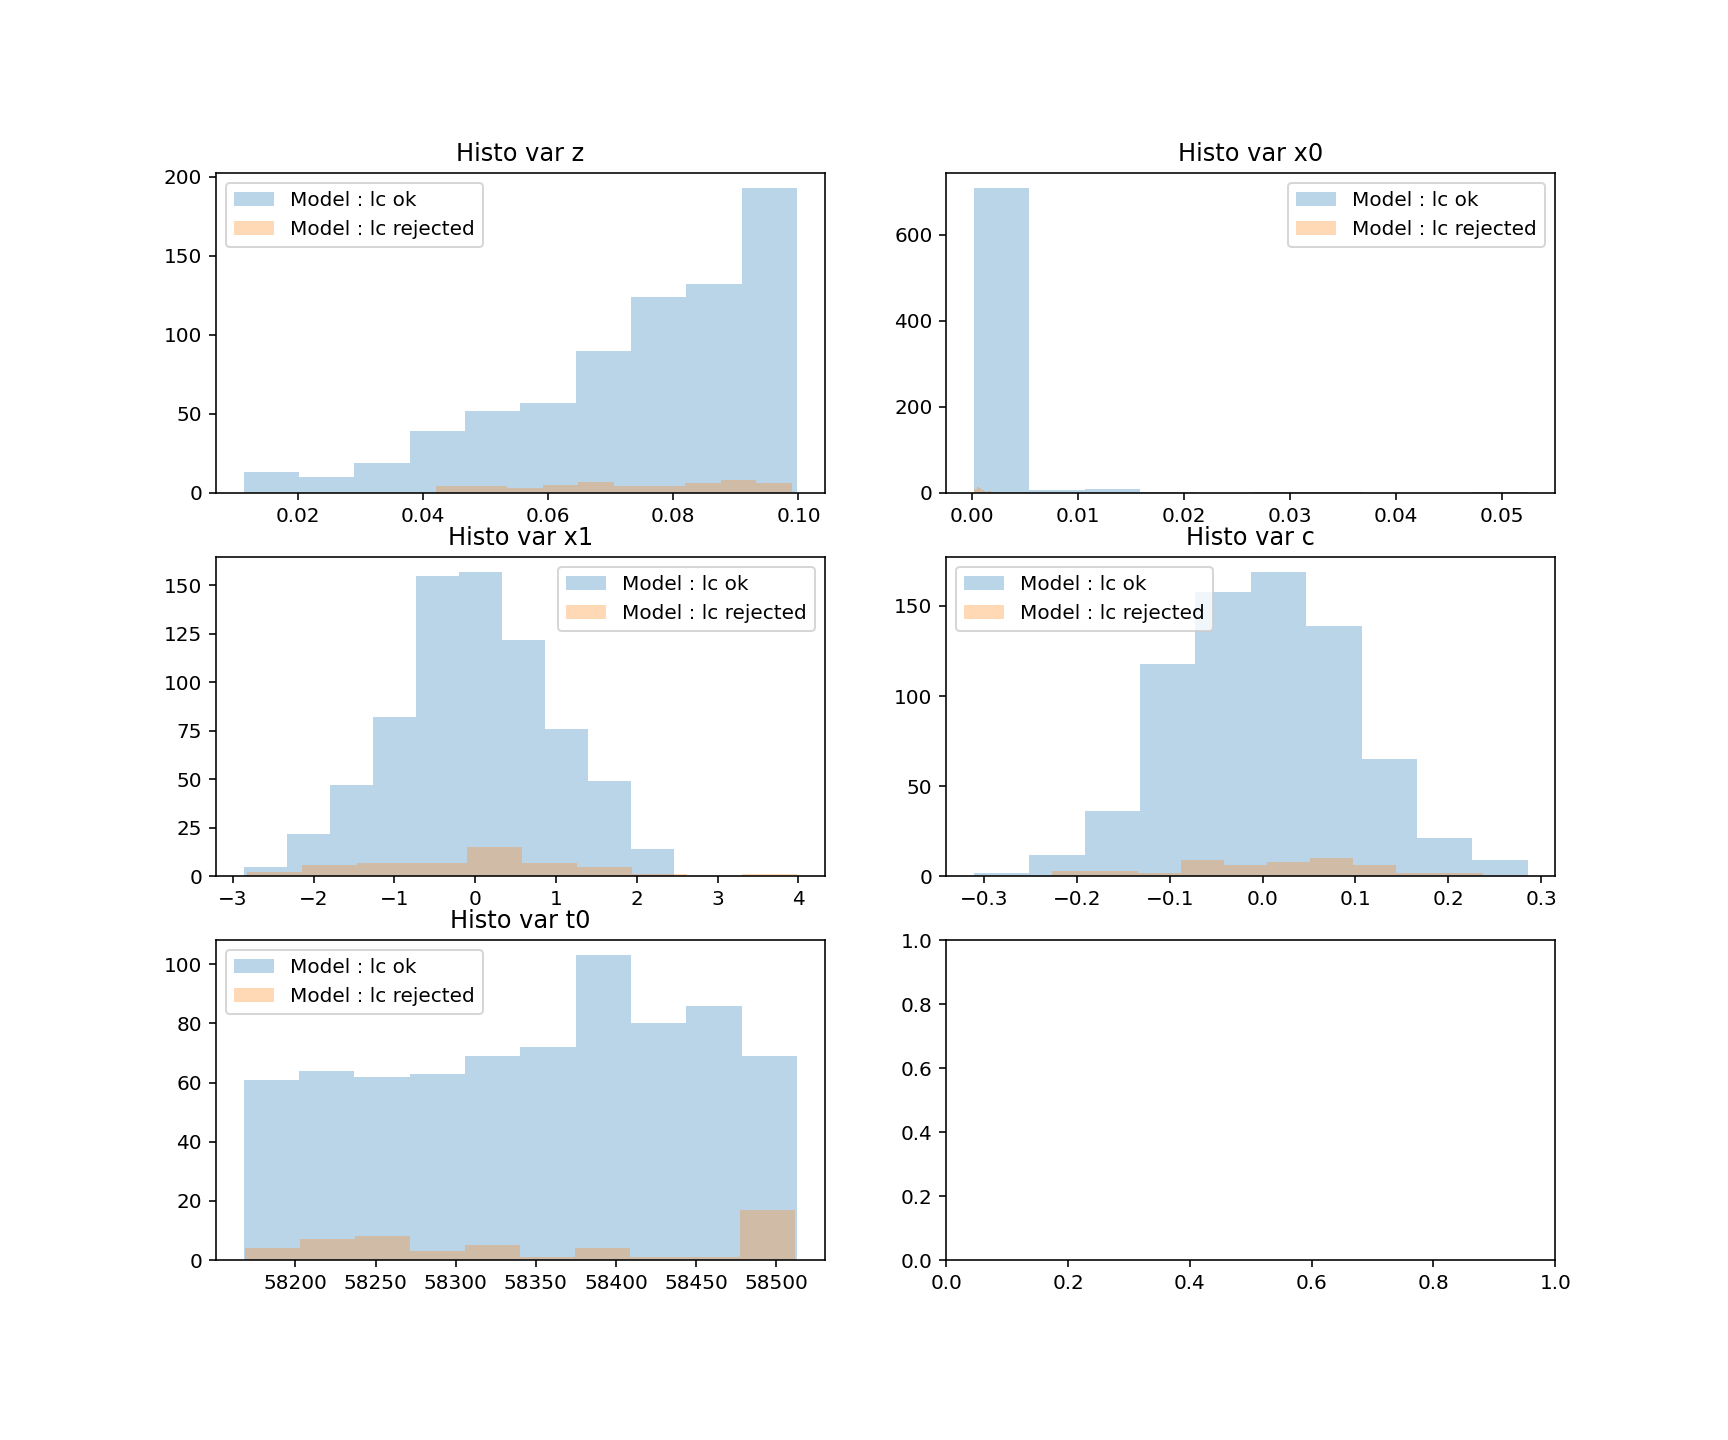

51


In [6]:
fig, axs = plt.subplots(3, 2, figsize=(12,10))
Histo2(lc.meta, 'lc ok')
if lc.meta_rejected is not None:
    Histo2(lc.meta_rejected, 'lc rejected')
    print(len(lc.meta_rejected))

# Writting data and metadata in an hdf5 file

In [7]:
clas = Write_LightCurve()
data = clas.write_data('Data', lc)
meta = clas.write_meta()
meta

lc is not an astropy.table.table.Table type <class 'simsurvey.simulsurvey.LightcurveCollection'>
OrderedDict([('directory', '/Users/manon/dataLC/Meta.hdf5'), ('file_name', 'Meta.dhf5')])


# Add meta data of light curve rejected on meta data file

In [8]:
clas_meta = Read_LightCurve(file_name='Meta.hdf5')
read_meta = clas_meta.Read_file(path='meta')
if lc.meta_rejected is not None:
    meta_rej = clas.Tab_metaRejected(lc)
    for i, rows in enumerate(meta_rej):
        read_meta.add_row(rows)
read_meta

z,t0,x0,x1,c,mwebv,ra,dec,mwebv_sfd98,idx_orig,path
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str6
0.09545085017442173,58409.885762310674,0.00042792653079786104,-0.6910283542340311,-0.04847308070074525,0.09844418189195032,38.993950764895985,32.24732852134754,0.09616798410277257,1,SN_0
0.09665627314283415,58472.06129339224,0.00018997578361501776,-0.07767154731863457,0.2302261815275927,0.6982093870378095,331.3243370103646,53.65453037854141,0.7037316619391935,3,SN_1
0.06768985090609805,58308.09870344577,0.0009713311416001163,-0.6676141479838038,-0.04220316246289517,0.050401214733667626,107.03614983624263,38.732286629945705,0.052952547645857675,4,SN_2
0.052395678566137256,58403.99765086157,0.001215187543928208,0.1070960548281009,0.054332361472258686,0.1510487760186715,347.7406801779318,41.90356231919069,0.14541423346547228,5,SN_3
0.09496615230696706,58379.78265947868,0.00037127595625553104,1.2021717465111479,0.0388261459238728,0.3179480958725112,97.59700656612729,18.870882600235063,0.3024550599754384,6,SN_4
0.07527202479792483,58410.33719046667,0.0007383778210616512,-0.5363280283701065,0.014404925939634284,0.05707139032221627,352.84433159582466,13.596297959557598,0.05810954184038318,7,SN_5
0.0708829178829646,58179.09237673494,0.0009831784917886843,-0.44920782155569733,-0.07722827434486919,0.16431841317682985,249.32562345389755,-2.2171639572552055,0.1724478183557102,10,SN_6
0.08361898317207836,58287.118391347474,0.0008259779713401135,1.8932215513458086,-0.12576507949379928,0.034956574248225125,248.93922399948596,8.355574549981563,0.05689950434768632,12,SN_7
0.0889024536282744,58512.7944569421,0.00024173828936575564,0.2208057724763456,0.2235140063441163,0.07825732198640899,314.07184192772405,11.101037847776945,0.08598148493395366,15,SN_8


# Reading csv file

In [9]:
import csv
from astropy.table import Table
home_dir = os.environ.get('HOME')
folder_dir = os.path.join(home_dir, 'dataLC/selection_tab.csv')
folder_dir_seuil = os.path.join(home_dir, 'dataLC/seuil_name_selec.csv')

table = Table.read(folder_dir) #Lecture du fichier csv
table_2 = Table.read(folder_dir_seuil) #Lecture du fichier csv

In [10]:
print(table,'\n\n', table_2)

 col  lim_col type     op1    
----- ------- ---- -----------
phase       0  int operator.le
phase       0  int operator.ge
phase     -10  int operator.le
phase      20  int operator.ge
 band    ztfr  str operator.eq
 band    ztfg  str operator.eq
 band    ztfi  str operator.eq 

 seuil  name_selec 
----- ------------
    4   nb_phase<0
   10   nb_phase>0
    1 nb_phase<-10
    1  nb_phase>20
    0 nb_band_ztfr
    0 nb_band_ztfg
    0 nb_band_ztfi


# Adding len of different table in function of the different selection

In [11]:
import operator
def selec_phase(Tab, csvFile, limSNR, selec=False, Verbose=False, Plot=False):
    
    SNR = Tab['flux'] / Tab['fluxerr']
    phase = (Tab['time'] - Tab.meta['t0']) / (1-Tab.meta['z'])
    Tab.add_columns([SNR, phase], names=['SNR', 'phase'])
    mask_SNR = Tab['SNR'] >= limSNR
    Tab = Tab[mask_SNR]
    len_tab = []
    
    for i, cols in enumerate(csvFile):
        if cols['col'] not in Tab.colnames:
            print(cols['col'], 'This column doesnt exist') 
    
        else:
            col = cols['col']
            op = eval(cols['op1'])
            type_ = eval(cols['type'])
            lim = type_(cols['lim_col'])
    
            mask = op(Tab[col], lim)
            new_Tab = Tab[mask]
        
            len_tab.append(len(new_Tab))
            
    if Verbose:
        print('min :', np.min(Tab['phase']), 'max :', np.max(Tab['phase']))
    if Plot:
        x = Tab['phase']
        y = Tab['flux']

        fig, axs = plt.subplots(1, 1, figsize=(10,8))
        axs.plot(x,y,marker = '*')
            
    if selec:
        return Tab
    else:
        return len_tab

In [12]:
clas2 = Read_LightCurve(file_name='Data.hdf5')
read_data = clas2.Read_file(path='SN_0')

rtot = []
r = []
rb = table_2['name_selec']
for i, row in enumerate(read_meta):
    if row['path'] == 'SN_{}'.format(i):
        read_data = clas2.Read_file(path='SN_{}'.format(i))
        len_Tab = selec_phase(read_data, table, 5)
        r.append(len_Tab)
    else : 
        b = np.full((len(table_2)), -1)
        r.append(b.tolist())

rtot = np.array(r)

for i in range(0, len(rtot[0])):
    line = [row[i] for row in rtot]
    c = Column(line)
    read_meta.add_column(c, name=rb[i])
    read_meta = read_meta
    
read_meta

/var/folders/8n/j9hb298x4xq39l_vtv55kkp00000gp/T/ipykernel_75663/1317654429.py:4: RuntimeWarning: invalid value encountered in true_divide
  SNR = Tab['flux'] / Tab['fluxerr']


z,t0,x0,x1,c,mwebv,ra,dec,mwebv_sfd98,idx_orig,path,nb_phase<0,nb_phase>0,nb_phase<-10,nb_phase>20,nb_band_ztfr,nb_band_ztfg,nb_band_ztfi
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str6,int64,int64,int64,int64,int64,int64,int64
0.09545085017442173,58409.885762310674,0.00042792653079786104,-0.6910283542340311,-0.04847308070074525,0.09844418189195032,38.993950764895985,32.24732852134754,0.09616798410277257,1,SN_0,2,9,2,5,7,4,0
0.09665627314283415,58472.06129339224,0.00018997578361501776,-0.07767154731863457,0.2302261815275927,0.6982093870378095,331.3243370103646,53.65453037854141,0.7037316619391935,3,SN_1,1,0,0,0,1,0,0
0.06768985090609805,58308.09870344577,0.0009713311416001163,-0.6676141479838038,-0.04220316246289517,0.050401214733667626,107.03614983624263,38.732286629945705,0.052952547645857675,4,SN_2,0,3,0,3,3,0,0
0.052395678566137256,58403.99765086157,0.001215187543928208,0.1070960548281009,0.054332361472258686,0.1510487760186715,347.7406801779318,41.90356231919069,0.14541423346547228,5,SN_3,12,35,8,35,27,20,0
0.09496615230696706,58379.78265947868,0.00037127595625553104,1.2021717465111479,0.0388261459238728,0.3179480958725112,97.59700656612729,18.870882600235063,0.3024550599754384,6,SN_4,0,3,0,0,3,0,0
0.07527202479792483,58410.33719046667,0.0007383778210616512,-0.5363280283701065,0.014404925939634284,0.05707139032221627,352.84433159582466,13.596297959557598,0.05810954184038318,7,SN_5,0,5,0,1,3,2,0
0.0708829178829646,58179.09237673494,0.0009831784917886843,-0.44920782155569733,-0.07722827434486919,0.16431841317682985,249.32562345389755,-2.2171639572552055,0.1724478183557102,10,SN_6,0,3,0,3,3,0,0
0.08361898317207836,58287.118391347474,0.0008259779713401135,1.8932215513458086,-0.12576507949379928,0.034956574248225125,248.93922399948596,8.355574549981563,0.05689950434768632,12,SN_7,11,23,4,10,16,10,8
0.0889024536282744,58512.7944569421,0.00024173828936575564,0.2208057724763456,0.2235140063441163,0.07825732198640899,314.07184192772405,11.101037847776945,0.08598148493395366,15,SN_8,0,0,0,0,0,0,0


# We apply our selection criteria

In [13]:
def selec(list_lenTable, csvFile):
    
    res = 1
    len_table = []
    
    for i, len_selec in enumerate(list_lenTable):
        if res:
            res &= operator.ge(len_selec, csvFile['seuil'][i])
        if not res:
            break
            
    return res

In [14]:
R, sel_list = [], []

for i, path in enumerate(read_meta['path']):
    class_data = Read_LightCurve(file_name='Data.hdf5')
    if path == 'SN_{}'.format(i):
        lc = class_data.Read_file(path=path)
        lc_len = selec_phase(lc, table, 5, selec=False)
        sel = selec(lc_len, table_2)
        R.append(sel)
    else:
        R.append(0)

pass_selec = Column(R)

if 'pass selec' in read_meta.colnames:
    read_meta['pass selec'] = pass_selec
else :
    read_meta.add_column(pass_selec, name = 'pass selec')
    
read_meta

/var/folders/8n/j9hb298x4xq39l_vtv55kkp00000gp/T/ipykernel_75663/1317654429.py:4: RuntimeWarning: invalid value encountered in true_divide
  SNR = Tab['flux'] / Tab['fluxerr']


z,t0,x0,x1,c,mwebv,ra,dec,mwebv_sfd98,idx_orig,path,nb_phase<0,nb_phase>0,nb_phase<-10,nb_phase>20,nb_band_ztfr,nb_band_ztfg,nb_band_ztfi,pass selec
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str6,int64,int64,int64,int64,int64,int64,int64,int64
0.09545085017442173,58409.885762310674,0.00042792653079786104,-0.6910283542340311,-0.04847308070074525,0.09844418189195032,38.993950764895985,32.24732852134754,0.09616798410277257,1,SN_0,2,9,2,5,7,4,0,0
0.09665627314283415,58472.06129339224,0.00018997578361501776,-0.07767154731863457,0.2302261815275927,0.6982093870378095,331.3243370103646,53.65453037854141,0.7037316619391935,3,SN_1,1,0,0,0,1,0,0,0
0.06768985090609805,58308.09870344577,0.0009713311416001163,-0.6676141479838038,-0.04220316246289517,0.050401214733667626,107.03614983624263,38.732286629945705,0.052952547645857675,4,SN_2,0,3,0,3,3,0,0,0
0.052395678566137256,58403.99765086157,0.001215187543928208,0.1070960548281009,0.054332361472258686,0.1510487760186715,347.7406801779318,41.90356231919069,0.14541423346547228,5,SN_3,12,35,8,35,27,20,0,1
0.09496615230696706,58379.78265947868,0.00037127595625553104,1.2021717465111479,0.0388261459238728,0.3179480958725112,97.59700656612729,18.870882600235063,0.3024550599754384,6,SN_4,0,3,0,0,3,0,0,0
0.07527202479792483,58410.33719046667,0.0007383778210616512,-0.5363280283701065,0.014404925939634284,0.05707139032221627,352.84433159582466,13.596297959557598,0.05810954184038318,7,SN_5,0,5,0,1,3,2,0,0
0.0708829178829646,58179.09237673494,0.0009831784917886843,-0.44920782155569733,-0.07722827434486919,0.16431841317682985,249.32562345389755,-2.2171639572552055,0.1724478183557102,10,SN_6,0,3,0,3,3,0,0,0
0.08361898317207836,58287.118391347474,0.0008259779713401135,1.8932215513458086,-0.12576507949379928,0.034956574248225125,248.93922399948596,8.355574549981563,0.05689950434768632,12,SN_7,11,23,4,10,16,10,8,1
0.0889024536282744,58512.7944569421,0.00024173828936575564,0.2208057724763456,0.2235140063441163,0.07825732198640899,314.07184192772405,11.101037847776945,0.08598148493395366,15,SN_8,0,0,0,0,0,0,0,0


# Light curve fit 

In [15]:
from ztf_fit import SN_fit

In [25]:
mask_pass_selec = read_meta['pass selec'] == 1
read_meta_test = read_meta[mask_pass_selec]

table_rows = []
keys = []
err = []
list_param = ['z', 't0', 'x0', 'x1', 'c']
b = dict(zip(list_param, [-1, -1, -1, -1, -1]))


for i, row in enumerate(read_meta_test):
        path = row['path']
        print(path)
        keys.append(path)
        data = Read_LightCurve(file_name='Data.hdf5')
        lc = data.Read_file(path=path)
        
        fit = SN_fit(lc)
        try:
            result, fitted_model = fit.fit_sn()
            #plot = fit.plot_sn()
            table_rows.append(result.parameters)
            err.append(result.errors)
            param_names = result.param_names
            
        except:
            print('None')
            a = np.full(5, -1)
            table_rows.append(a.tolist())
            err.append(b)

SN_3
None
SN_7
5
SN_10


/Users/manon/opt/anaconda3/lib/python3.9/site-packages/sncosmo/fitting.py:235: RuntimeWarning: invalid value encountered in true_divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]


5
SN_12
5
SN_24
5
SN_25
5
SN_28
5
SN_30
5
SN_32
5
SN_35
5
SN_38
5
SN_58
5
SN_63
5
SN_70
5
SN_83
5
SN_88
5
SN_99
5
SN_101
5
SN_102
5
SN_104
5
SN_111
5
SN_112
5
SN_116
5
SN_117
5
SN_120
5
SN_121
5
SN_125
5
SN_129
5
SN_133
None
SN_136
5
SN_137
None
SN_139
5
SN_140
5
SN_141
5
SN_149
5
SN_151
5
SN_158
None
SN_160
5
SN_163
5
SN_170
5
SN_174
5
SN_177
None
SN_182
5
SN_188
5
SN_189
5
SN_191
5
SN_193
5
SN_194
5
SN_196
None
SN_198
5
SN_200
5
SN_206
5
SN_209
5
SN_210
None
SN_211


/Users/manon/opt/anaconda3/lib/python3.9/site-packages/sncosmo/models.py:813: RuntimeWarning: overflow encountered in power
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))
/Users/manon/opt/anaconda3/lib/python3.9/site-packages/sncosmo/models.py:812: RuntimeWarning: invalid value encountered in multiply
  return (self._parameters[0] * (m0 + self._parameters[1] * m1) *
/Users/manon/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


None
SN_213
None
SN_219
None
SN_224
5
SN_228
None
SN_229
5
SN_233
5
SN_240
5
SN_249
5
SN_251
5
SN_257
5
SN_259
None
SN_262
5
SN_267
5
SN_269
5
SN_270
5
SN_278
5
SN_284
5
SN_291
5
SN_292
5
SN_294
None
SN_296
5
SN_297
5
SN_307
5
SN_308
5
SN_309
5
SN_312
5
SN_314
5
SN_318
5
SN_324
5
SN_334
5
SN_341
5
SN_345
None
SN_348
5
SN_355
5
SN_356
5
SN_357
5
SN_363
5
SN_366
5
SN_368
None
SN_379
5
SN_380
5
SN_381
5
SN_384
5
SN_385
5
SN_398
5
SN_400
5
SN_404
5
SN_406
5
SN_417
5
SN_425
5
SN_430
5
SN_431
5
SN_435
5
SN_444
5
SN_454
5
SN_455
None
SN_457
5
SN_476
5
SN_478
None
SN_479
5
SN_481
None
SN_485
5
SN_487
5
SN_491
5
SN_492
5
SN_495
5
SN_497
5
SN_502
5
SN_504
5
SN_522
5
SN_525
None
SN_526
5
SN_531
5
SN_532
5
SN_537
5
SN_538
None
SN_543
5
SN_548
5
SN_549
5
SN_554
5
SN_556
None
SN_559
5
SN_566
5
SN_568
5
SN_572
None
SN_574
5
SN_576
5
SN_582
5
SN_584
5
SN_588
5
SN_590
5
SN_597
5
SN_608
5
SN_611
5
SN_613
5
SN_614
5
SN_617
5
SN_618
5
SN_632
None
SN_634
5
SN_642
5
SN_643
5
SN_645
5
SN_653
5
SN_656
None
SN

# Fitting parameters

In [26]:
err_name = ['z_err', 't0_err', 'x0_err', 'x1_err', 'c_err']
err = Table(err)

param_names2 = ['z_fit', 't0_fit', 'x0_fit', 'x1_fit', 'c_fit']

c = Column(keys, name='path')
tab_param = Table(rows=table_rows, names=param_names2)
tab_param.add_column(c, index=0) 
tab_param.add_columns([err['z'], err['t0'], err['x0'], err['x1'], err['c']], names=err_name)
tab_param

path,z_fit,t0_fit,x0_fit,x1_fit,c_fit,z_err,t0_err,x0_err,x1_err,c_err
str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
SN_3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
SN_7,0.08262008840564321,58287.0295716163,0.0007394551017186815,1.731178580793776,-0.09972420259278933,0.0019936506539960513,0.13666455579004833,1.2705748766602636e-05,0.18395761183910442,0.015189370316412494
SN_10,0.0910352656412344,58345.68248918102,0.0005520408466150395,0.9147179526762549,-0.03194286510464978,0.0019247511656605779,0.14528598091419553,1.0932871577924551e-05,0.16310593760006156,0.01692821354165314
SN_12,0.06797604597559624,58358.10198427868,0.0002189531289127792,1.804338551923505,0.4312106920667669,0.0019910162894134636,0.24343627595953876,1.1562927000595779e-05,0.3105788612420592,0.038132464995729407
SN_24,0.03270522339202812,58441.007293046685,0.00033358378227385077,-0.19230519034802357,0.6849956137910806,0.0019356255300488397,0.09489882002890226,6.926382184096071e-06,0.1166673310573204,0.01599109639239429
SN_25,0.06487735947731668,58379.067954996965,0.0008556299280289524,0.29126750936508883,0.0730064141682101,0.0017376871117896209,0.07859085252493969,7.030142778731503e-06,0.09339790307632163,0.007800055711562462
SN_28,0.07205860631440518,58442.82894673107,0.0010687505664335273,1.118628871454328,-0.08556790115396624,0.0013359501079100514,0.13732891269319225,1.9998796949956237e-05,0.177346380857903,0.014930255865665447
SN_30,0.05879192843863208,58347.72375210071,0.0011077122945872442,0.6246108880740012,0.019123919569214436,0.001989852024177525,0.08088540682729217,8.421016511937552e-06,0.06604554790272651,0.00659627389712658
SN_32,0.0953854976668939,58437.6185405491,0.00035591086554773984,-0.5129920196722343,-0.0009510504408560402,0.001858927504722302,0.21104888647823827,6.232594718598341e-06,0.24761603450467085,0.020375158591463695


In [27]:
for i in range(0, len(tab_param.columns)):
    col_name = tab_param.columns[i]
    if col_name.name == 'path':
        read_meta_test['path'] = tab_param['path']
    else:    
        read_meta_test.add_column(tab_param[col_name.name], name=col_name.name)
read_meta_test

z,t0,x0,x1,c,mwebv,ra,dec,mwebv_sfd98,idx_orig,path,nb_phase<0,nb_phase>0,nb_phase<-10,nb_phase>20,nb_band_ztfr,nb_band_ztfg,nb_band_ztfi,pass selec,z_fit,t0_fit,x0_fit,x1_fit,c_fit,z_err,t0_err,x0_err,x1_err,c_err
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str6,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.052395678566137256,58403.99765086157,0.001215187543928208,0.1070960548281009,0.054332361472258686,0.1510487760186715,347.7406801779318,41.90356231919069,0.14541423346547228,5,SN_3,12,35,8,35,27,20,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
0.08361898317207836,58287.118391347474,0.0008259779713401135,1.8932215513458086,-0.12576507949379928,0.034956574248225125,248.93922399948596,8.355574549981563,0.05689950434768632,12,SN_7,11,23,4,10,16,10,8,1,0.08262008840564321,58287.0295716163,0.0007394551017186815,1.731178580793776,-0.09972420259278933,0.0019936506539960513,0.13666455579004833,1.2705748766602636e-05,0.18395761183910442,0.015189370316412494
0.09003547803030851,58345.72359333526,0.0007901399597999205,1.039205630466622,-0.12964930098535607,0.10065234464004486,257.39995697270933,18.303710001113416,0.07829071706023374,18,SN_10,11,23,5,13,17,11,6,1,0.0910352656412344,58345.68248918102,0.0005520408466150395,0.9147179526762549,-0.03194286510464978,0.0019247511656605779,0.14528598091419553,1.0932871577924551e-05,0.16310593760006156,0.01692821354165314
0.06697638013022884,58357.84810886885,0.0009228729782878108,1.673265725226615,0.031044129117307313,0.3853267216486996,83.70365757530979,47.92863651388504,0.4024389239956446,20,SN_12,8,25,3,11,25,8,0,1,0.06797604597559624,58358.10198427868,0.0002189531289127792,1.804338551923505,0.4312106920667669,0.0019910162894134636,0.24343627595953876,1.1562927000595779e-05,0.3105788612420592,0.038132464995729407
0.03170522341320423,58440.99159285662,0.00305788643144089,-0.3099819944496375,0.1338218648824978,0.6022408147251205,78.02873982524733,28.30967900298078,0.6206030549152874,37,SN_24,30,29,7,13,45,14,0,1,0.03270522339202812,58441.007293046685,0.00033358378227385077,-0.19230519034802357,0.6849956137910806,0.0019356255300488397,0.09489882002890226,6.926382184096071e-06,0.1166673310573204,0.01599109639239429
0.06387742604171176,58378.95643866294,0.0009903743468132075,0.08039986348516276,0.02454784114335688,0.03434031238269509,17.712738866483445,23.52535698825329,0.034404360453216404,38,SN_25,39,34,20,9,33,31,9,1,0.06487735947731668,58379.067954996965,0.0008556299280289524,0.29126750936508883,0.0730064141682101,0.0017376871117896209,0.07859085252493969,7.030142778731503e-06,0.09339790307632163,0.007800055711562462
0.07105869508176761,58442.970766011014,0.001129174628983081,1.409161656668816,-0.10798435387632532,0.020036820825226537,70.67273924574086,-18.64716291460954,0.03183290015463494,41,SN_28,27,11,16,7,21,17,0,1,0.07205860631440518,58442.82894673107,0.0010687505664335273,1.118628871454328,-0.08556790115396624,0.0013359501079100514,0.13732891269319225,1.9998796949956237e-05,0.177346380857903,0.014930255865665447
0.05779192857990089,58347.72633678898,0.0012267181244984924,0.5835253719161301,-0.006338460811777429,0.02638548480741624,11.284065114148657,-18.27009962212074,0.02081537312196715,43,SN_30,19,92,3,49,55,46,10,1,0.05879192843863208,58347.72375210071,0.0011077122945872442,0.6246108880740012,0.019123919569214436,0.001989852024177525,0.08088540682729217,8.421016511937552e-06,0.06604554790272651,0.00659627389712658
0.0943855011041209,58437.609909997576,0.00041507340584388775,-0.49979759347924047,-0.06259965801985316,0.03472485672421463,131.76362703234375,16.040211313338283,0.02114552891098309,46,SN_32,12,23,4,7,22,13,0,1,0.0953854976668939,58437.6185405491,0.00035591086554773984,-0.5129920196722343,-0.0009510504408560402,0.001858927504722302,0.21104888647823827,6.232594718598341e-06,0.24761603450467085,0.020375158591463695


In [28]:
def diff(param_simu, param_fit, param_err):
    diff_ = []
    for i, row in enumerate(read_meta_test):
        if row[param_fit] == -1:
            diff_.append(-1)
        else:
            p_simu = row[param_simu]
            p_fit = row[param_fit]
            p_err = row[param_err]
            diff_.append((p_simu-p_fit)/p_err)
    return diff_

    #read_meta_test.add_column(diff, name=diff_name[i])
    
#read_meta_test

#moy = np.mean(diff_z)
#ecarttype = np.std(diff_z)

#plt.figure(figsize=(6,5))
#plt.hist(diff_z, bins=range(int(min(diff_z)), int(max(diff_z))))
#print('moyenne =', moy)
#print('ecarttype =', ecarttype)
#plt.show()

In [29]:
param_simu = ['z', 'x0', 'x1', 'c', 't0']
param_fit = ['z_fit', 'x0_fit', 'x1_fit', 'c_fit', 't0_fit']
param_err = ['z_err', 'x0_err', 'x1_err', 'c_err', 't0_err']
diff_name = ['diff_z', 'diff_x0', 'diff_x1', 'diff_c', 'diff_t0']

meta_new = read_meta_test.copy()
for i in range(0, len(param_simu)):
    t = diff(param_simu[i], param_fit[i], param_err[i])
    meta_new.add_column(t, name=diff_name[i])
meta_new

z,t0,x0,x1,c,mwebv,ra,dec,mwebv_sfd98,idx_orig,path,nb_phase<0,nb_phase>0,nb_phase<-10,nb_phase>20,nb_band_ztfr,nb_band_ztfg,nb_band_ztfi,pass selec,z_fit,t0_fit,x0_fit,x1_fit,c_fit,z_err,t0_err,x0_err,x1_err,c_err,diff_z,diff_x0,diff_x1,diff_c,diff_t0
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str6,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.052395678566137256,58403.99765086157,0.001215187543928208,0.1070960548281009,0.054332361472258686,0.1510487760186715,347.7406801779318,41.90356231919069,0.14541423346547228,5,SN_3,12,35,8,35,27,20,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
0.08361898317207836,58287.118391347474,0.0008259779713401135,1.8932215513458086,-0.12576507949379928,0.034956574248225125,248.93922399948596,8.355574549981563,0.05689950434768632,12,SN_7,11,23,4,10,16,10,8,1,0.08262008840564321,58287.0295716163,0.0007394551017186815,1.731178580793776,-0.09972420259278933,0.0019936506539960513,0.13666455579004833,1.2705748766602636e-05,0.18395761183910442,0.015189370316412494,0.5010380150770036,6.8097418901323925,0.8808712449135339,-1.714414512158686,0.6499105101461482
0.09003547803030851,58345.72359333526,0.0007901399597999205,1.039205630466622,-0.12964930098535607,0.10065234464004486,257.39995697270933,18.303710001113416,0.07829071706023374,18,SN_10,11,23,5,13,17,11,6,1,0.0910352656412344,58345.68248918102,0.0005520408466150395,0.9147179526762549,-0.03194286510464978,0.0019247511656605779,0.14528598091419553,1.0932871577924551e-05,0.16310593760006156,0.01692821354165314,-0.5194373323487592,21.778277691073054,0.7632320418378201,-5.771810217321058,0.28291892982825345
0.06697638013022884,58357.84810886885,0.0009228729782878108,1.673265725226615,0.031044129117307313,0.3853267216486996,83.70365757530979,47.92863651388504,0.4024389239956446,20,SN_12,8,25,3,11,25,8,0,1,0.06797604597559624,58358.10198427868,0.0002189531289127792,1.804338551923505,0.4312106920667669,0.0019910162894134636,0.24343627595953876,1.1562927000595779e-05,0.3105788612420592,0.038132464995729407,-0.5020882303589244,60.877306354936096,-0.4220275203943589,-10.49411736152582,-1.0428824086593347
0.03170522341320423,58440.99159285662,0.00305788643144089,-0.3099819944496375,0.1338218648824978,0.6022408147251205,78.02873982524733,28.30967900298078,0.6206030549152874,37,SN_24,30,29,7,13,45,14,0,1,0.03270522339202812,58441.007293046685,0.00033358378227385077,-0.19230519034802357,0.6849956137910806,0.0019356255300488397,0.09489882002890226,6.926382184096071e-06,0.1166673310573204,0.01599109639239429,-0.5166288433892751,393.32259998912764,-1.0086525768194485,-34.467539647296036,-0.16544136229876702
0.06387742604171176,58378.95643866294,0.0009903743468132075,0.08039986348516276,0.02454784114335688,0.03434031238269509,17.712738866483445,23.52535698825329,0.034404360453216404,38,SN_25,39,34,20,9,33,31,9,1,0.06487735947731668,58379.067954996965,0.0008556299280289524,0.29126750936508883,0.0730064141682101,0.0017376871117896209,0.07859085252493969,7.030142778731503e-06,0.09339790307632163,0.007800055711562462,-0.5754392887077947,19.166668875047794,-2.257734263130213,-6.212593193792237,-1.4189480128935275
0.07105869508176761,58442.970766011014,0.001129174628983081,1.409161656668816,-0.10798435387632532,0.020036820825226537,70.67273924574086,-18.64716291460954,0.03183290015463494,41,SN_28,27,11,16,7,21,17,0,1,0.07205860631440518,58442.82894673107,0.0010687505664335273,1.118628871454328,-0.08556790115396624,0.0013359501079100514,0.13732891269319225,1.9998796949956237e-05,0.177346380857903,0.014930255865665447,-0.7484645023172463,3.021384871337772,1.6382222394900439,-1.5014111562487926,1.0326979014487863
0.05779192857990089,58347.72633678898,0.0012267181244984924,0.5835253719161301,-0.006338460811777429,0.02638548480741624,11.284065114148657,-18.27009962212074,0.02081537312196715,4

<IPython.core.display.Javascript object>


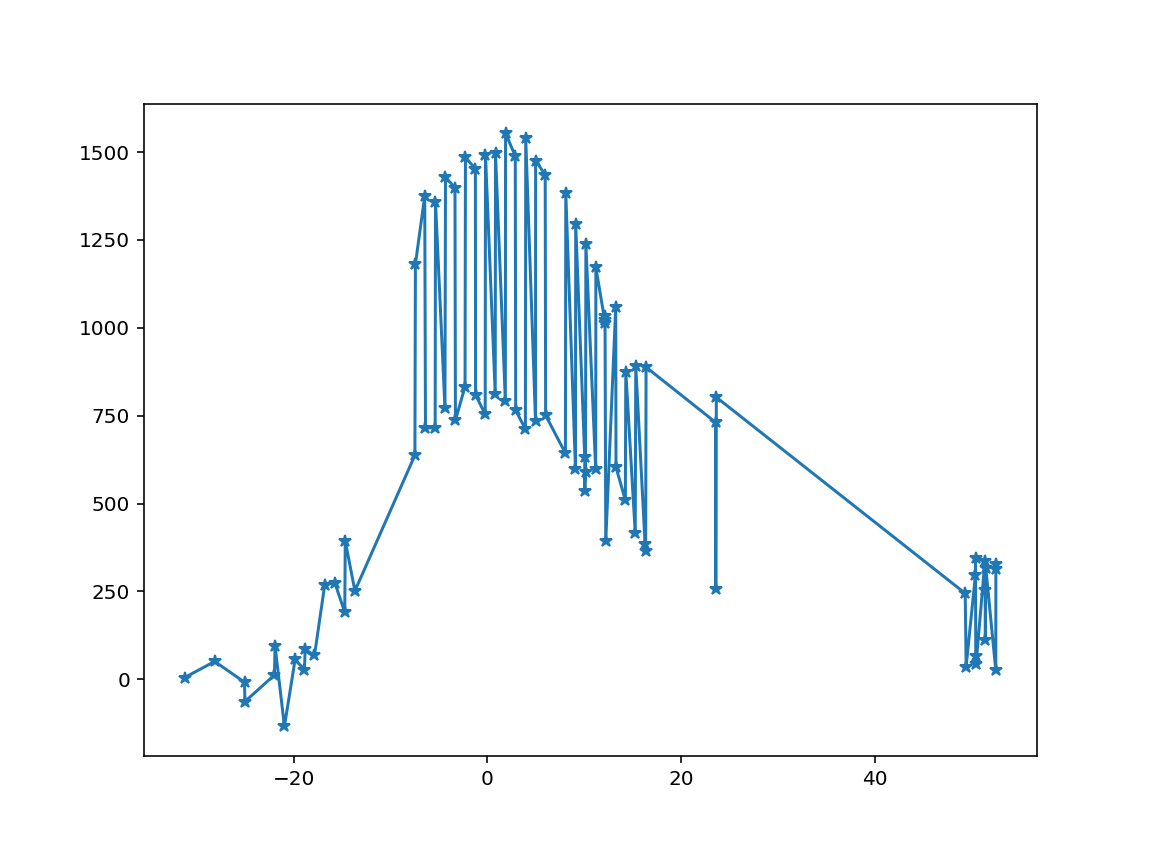

{'c': 0.056083609584598904, 'dec': 17.59280452613252, 'idx_orig': 176, 'mwebv': 0.7290543465921274, 'mwebv_sfd98': 0.727312373354259, 'ra': 88.78635002826529, 't0': 58374.68869641808, 'x0': 0.004533371812331181, 'x1': 1.9980817913600282, 'z': 0.03316105953048823}


In [60]:
path = 'SN_125'
classs = Read_LightCurve(file_name='Data.hdf5')
read_data_SN = classs.Read_file(path=path)

phase = (read_data_SN['time'] - read_data_SN.meta['t0']) / (1-read_data_SN.meta['z'])

plt.figure(figsize=(8,6))
plt.plot(phase, read_data_SN['flux'], marker='*')
print(read_data_SN.meta)

# We have a problem with different values of z and x0 mainly
## To do the histo, I have applied a mask with diff_z < 5 and diff_x0 <3

<IPython.core.display.Javascript object>


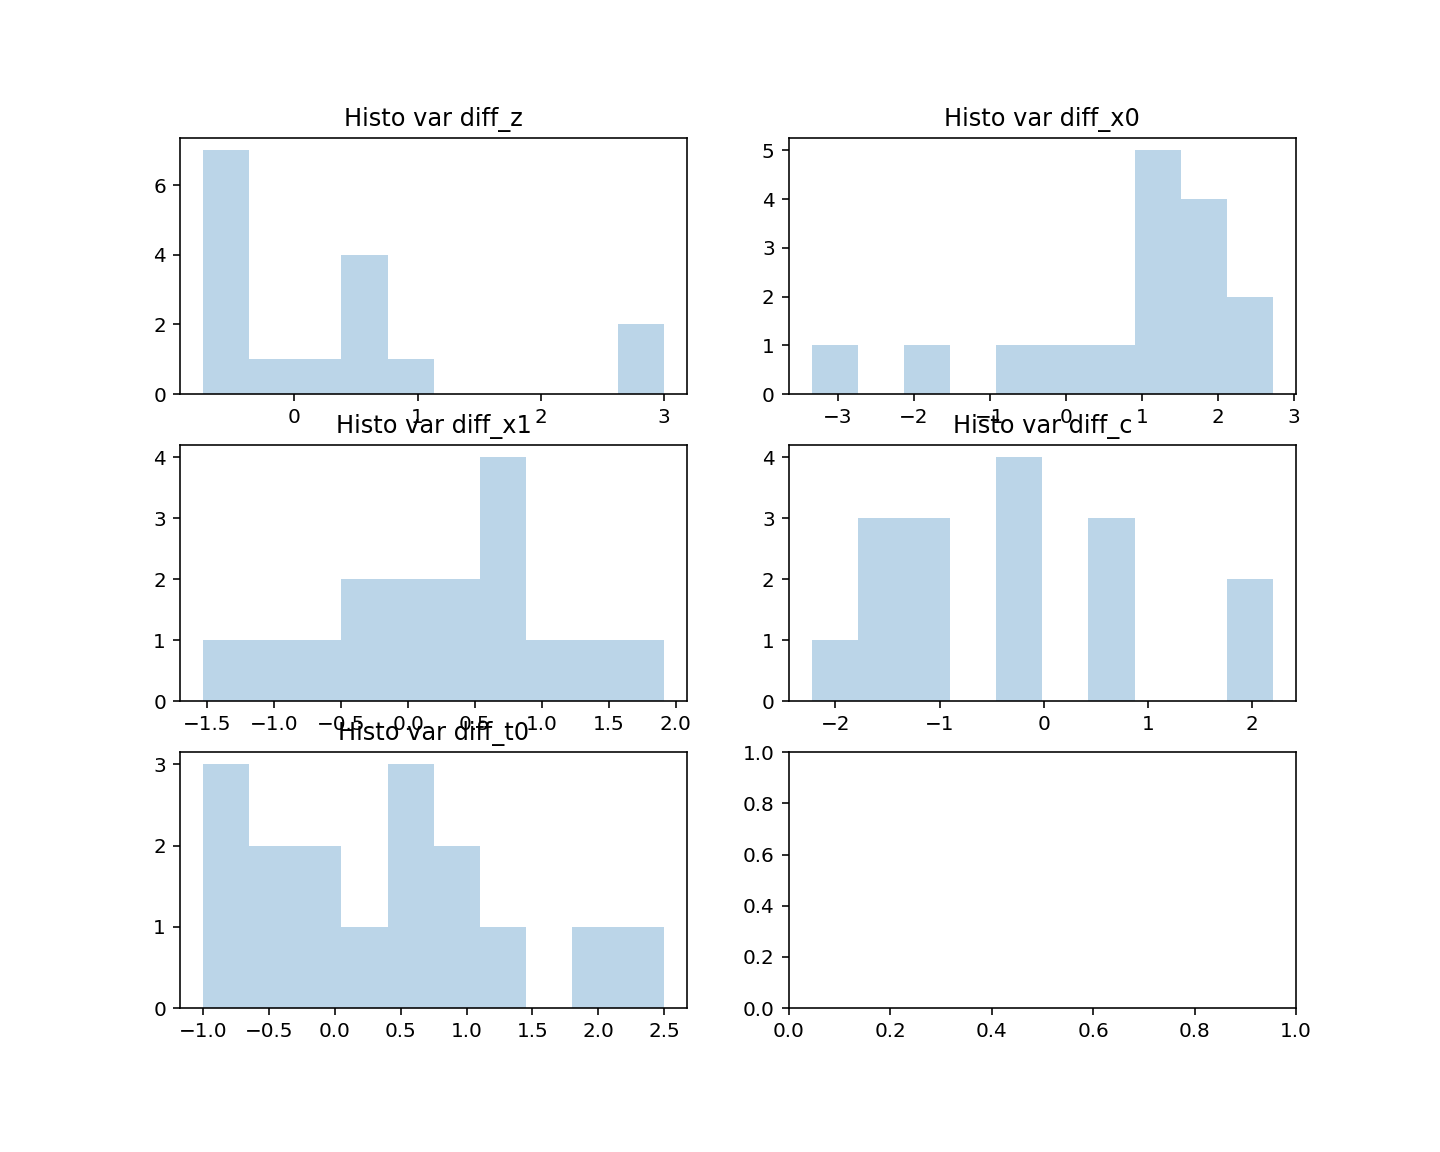

diff_z / moyenne = 0.3009717560617786 / equart type = 1.1047322253791467
diff_x0 / moyenne = 0.8215554715126707 / equart type = 1.5408961983119336
diff_x1 / moyenne = 0.27171889520660836 / equart type = 0.8812266357164208
diff_c / moyenne = -0.33555924908225077 / equart type = 1.2293652396508457
diff_t0 / moyenne = 0.3164401360686977 / equart type = 0.9558671950336035


In [78]:
var_ = ['diff_z', 'diff_x0', 'diff_x1', 'diff_c', 'diff_t0']
dico_ = dict(zip(var_, [(0,0), (0,1), (1,0), (1,1), (2,0)]))
range_ = [(-1,5), (-5,50), (-2,2), (-16, 10), (0,3)]

fig, axs = plt.subplots(3, 2, figsize=(10,8))
for i, variables in enumerate(var_):
    ipos = dico_[variables][0]
    jpos = dico_[variables][1]
    
    mask = meta_new[variables] != -1
    meta_new = meta_new[mask]
    
    mask1 = meta_new['diff_x0']<3
    mask2 = meta_new['diff_z']<5
    mask_diff = mask1 & mask2
    
    axs[ipos, jpos].hist(meta_new[variables][mask_diff], alpha = 0.3) #range = range_[i]
    axs[ipos, jpos].set_title('Histo var {}'.format(variables))
    moy = np.mean(meta_new[variables][mask_diff])
    ecarttype = np.std(meta_new[variables][mask_diff])
    print(variables, '/ moyenne =', moy, '/ equart type =', ecarttype)

<IPython.core.display.Javascript object>


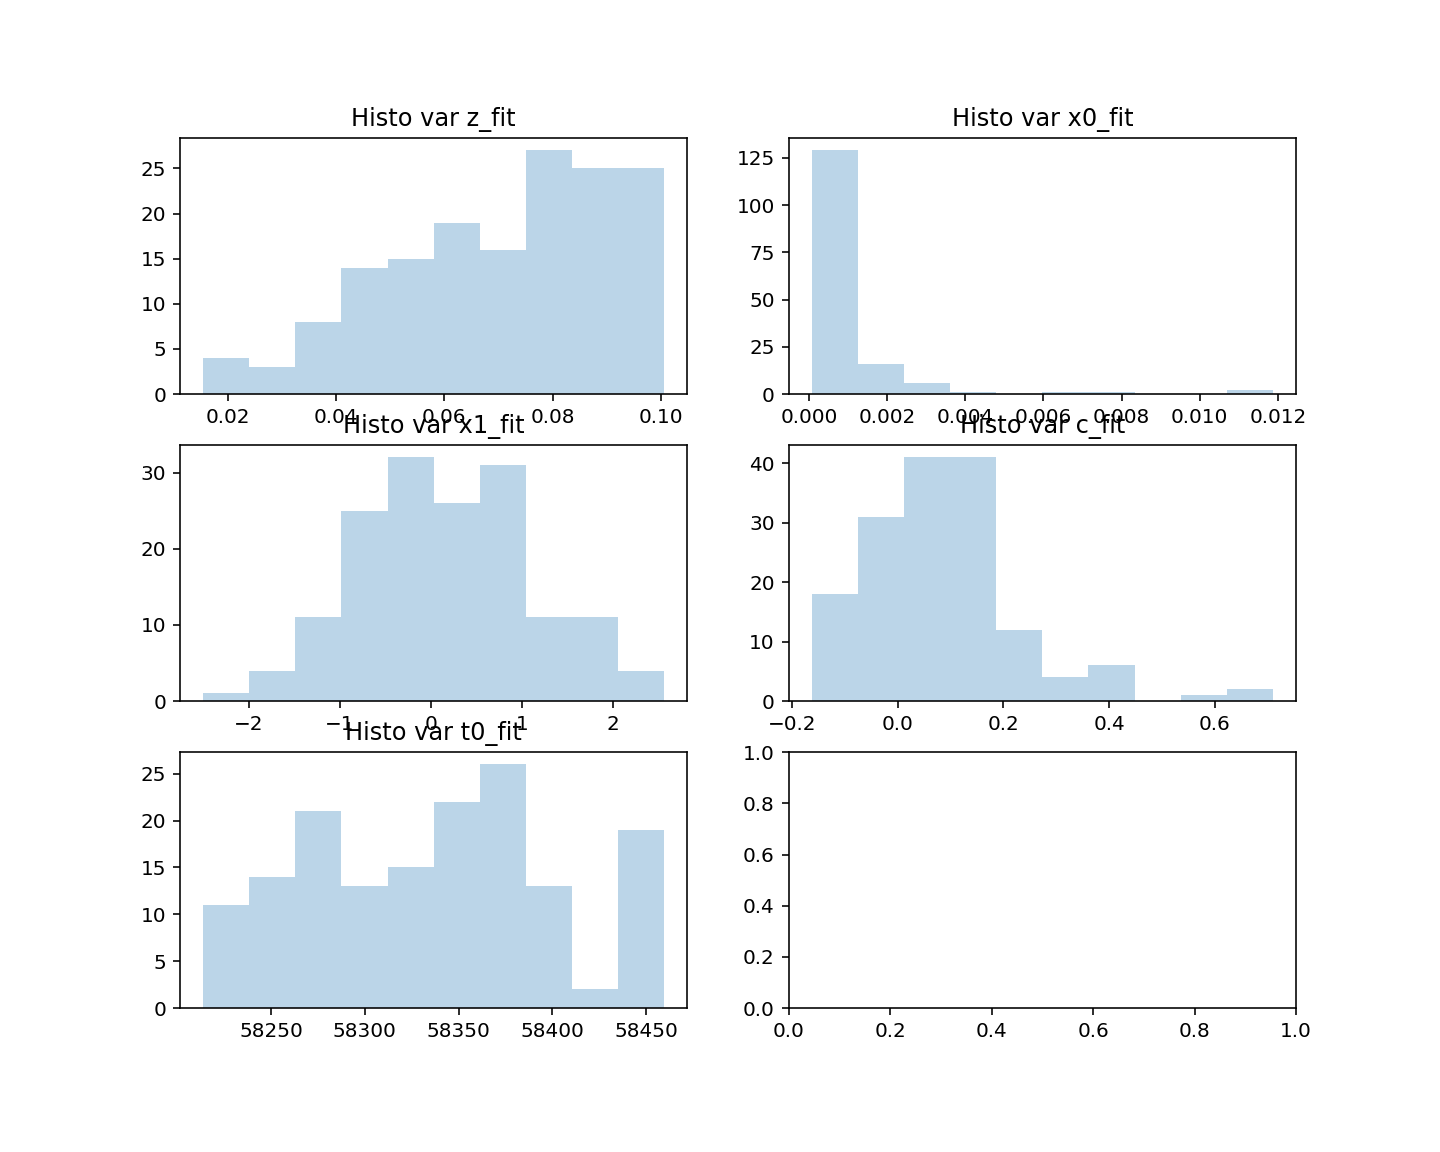

In [79]:
var = ['z_fit', 'x0_fit', 'x1_fit', 'c_fit', 't0_fit']
dico = dict(zip(var, [(0,0), (0,1), (1,0), (1,1), (2,0)]))

fig, axs = plt.subplots(3, 2, figsize=(10,8))
for variables in var :
    ipos = dico[variables][0]
    jpos = dico[variables][1]
    
    mask = meta_new[variables] != -1
     
    axs[ipos, jpos].hist(meta_new[variables][mask], alpha = 0.3)
    axs[ipos, jpos].set_title('Histo var {}'.format(variables))